# 第14章 目标检测实例

## 14.1 数据集简介
	这里使用VOC2007数据集，其目录结构如14-1 所示。
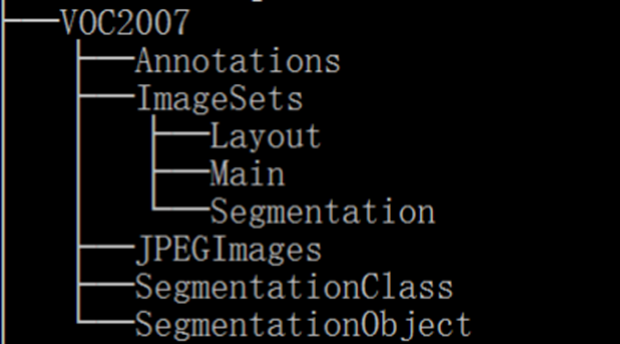

各个目录含义如下：  
1）Annotations中存储的是.xml文件，即标注数据，标注了影像中的目标类型以及边界框bbox；  
2）ImageSet中存储的都是一些txt文件，其实就是各个挑战任务所使用的图片序号，VOC比赛是将所有的图片存在一起，然后不同的挑战任务使用的图片就用一个txt存储使用图片的文件名即可；  
3）JPEGImages文件夹中存储了数据集的所有图片；  
4）SegmentationClass存储了类别分割的标注png。  
5）SegmentationObject存储了实例分割的标注png。   
其中类别分割与实例分割的区别是类别分割只区分物体的类别，同样类别的两个不同物体的像素分配同一个值；而实例分割不只区分目标的类别，而且同样类别的两个不同的对象，也要进行区分。例如两个人，在类别分割中都标注为person，而实例分割就需要分割为person1、person2。
本项目这次主要使用1、2、3目录下的内容。  
项目主要流程分析如下。  
1）导入需要的模块。  
2）导入数据，集成训练数据、验证数据的标注信息等。  
3）提取特征。  
4）恢复模型权重参数。  
5）可视化训练后的特征图。  
6）实现RPN网络。  
7）实现RoI Pooling。  
8）可视化最后结果。

## 14.2 准备数据
生成训练时需要的文件：2007_train.txt and 2007_val.txt

In [1]:
import os
import random
import xml.etree.ElementTree as ET

from utils.utils import get_classes

In [2]:
# annotation_mode为2代表获得训练用的2007_train.txt、2007_val.txt
annotation_mode     = 2
#-------------------------------------------------------------------#
#   用于生成2007_train.txt、2007_val.txt的目标信息
#   与训练和预测所用的classes_path一致即可
#-------------------------------------------------------------------#

In [3]:
classes_path        = 'model_data/voc_classes.txt'
#--------------------------------------------------------------------------------------------------------------------------------#
#   trainval_percent用于指定(训练集+验证集)与测试集的比例，默认情况下 (训练集+验证集):测试集 = 9:1 
#   train_percent用于指定(训练集+验证集)中训练集与验证集的比例，默认情况下 训练集:验证集 = 9:1 
#   仅在annotation_mode为0和1的时候有效
#--------------------------------------------------------------------------------------------------------------------------------#
trainval_percent    = 0.9
train_percent       = 0.9
#-------------------------------------------------------#
#   指向VOC数据集所在的文件夹
#   默认指向根目录下的VOC数据集
#-------------------------------------------------------#

In [4]:
VOCdevkit_path  = '../data/VOC2007/'

VOCdevkit_sets  = [('2007', 'train'), ('2007', 'val')]
classes, _      = get_classes(classes_path)


In [5]:
def convert_annotation(year, image_id, list_file):
    in_file = open(os.path.join(VOCdevkit_path, 'Annotations/%s.xml'%(image_id)), encoding='utf-8')
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = 0 
        if obj.find('difficult')!=None:
            difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(float(xmlbox.find('xmin').text)), int(float(xmlbox.find('ymin').text)), int(float(xmlbox.find('xmax').text)), int(float(xmlbox.find('ymax').text)))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id)) 


In [6]:
random.seed(0)
if annotation_mode == 0 or annotation_mode == 1:
    print("Generate txt in ImageSets.")
    xmlfilepath     = os.path.join(VOCdevkit_path, 'Annotations')
    saveBasePath    = os.path.join(VOCdevkit_path, 'ImageSets/Main')
    temp_xml        = os.listdir(xmlfilepath)
    total_xml       = []
    for xml in temp_xml:
        if xml.endswith(".xml"):
            total_xml.append(xml)

    num     = len(total_xml)  
    list    = range(num)  
    tv      = int(num*trainval_percent)  
    tr      = int(tv*train_percent)  
    trainval= random.sample(list,tv)  
    train   = random.sample(trainval,tr)  
    
    print("train and val size",tv)
    print("train size",tr)
    ftrainval   = open(os.path.join(saveBasePath,'trainval.txt'), 'w')  
    ftest       = open(os.path.join(saveBasePath,'test.txt'), 'w')  
    ftrain      = open(os.path.join(saveBasePath,'train.txt'), 'w')  
    fval        = open(os.path.join(saveBasePath,'val.txt'), 'w')  
    
    for i in list:  
        name=total_xml[i][:-4]+'\n'  
        if i in trainval:  
            ftrainval.write(name)  
            if i in train:  
                ftrain.write(name)  
            else:  
                fval.write(name)  
        else:  
            ftest.write(name)  
    
    ftrainval.close()  
    ftrain.close()  
    fval.close()  
    ftest.close()
    print("Generate txt in ImageSets done.")

if annotation_mode == 0 or annotation_mode == 2:
    print("Generate 2007_train.txt and 2007_val.txt for train.")
    for year, image_set in VOCdevkit_sets:
        image_ids = open(os.path.join(VOCdevkit_path, 'ImageSets/Main/%s.txt'%(image_set)), encoding='utf-8').read().strip().split()
        list_file = open('%s_%s.txt'%(year, image_set), 'w', encoding='utf-8')
        for image_id in image_ids:
            list_file.write('%s/JPEGImages/%s.jpg'%(os.path.abspath(VOCdevkit_path), image_id))

            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        list_file.close()
    print("Generate 2007_train.txt and 2007_val.txt for train done.")

Generate 2007_train.txt and 2007_val.txt for train.
Generate 2007_train.txt and 2007_val.txt for train done.
